In [59]:
import torch
import matplotlib.pyplot as plt
import polytope as pc
import numpy as np

In [120]:
state_dimen = 2
action_dimen = 2
x_max = 10
y_max = 10
T = 15
R = 200
E = 10
N = 500

obstacle_constraints = [pc.box2poly([[4, 5], [4, 5]])]
safe_constraint = pc.box2poly([[7, 8], [7, 8]])

In [129]:
def dynamics(s, a):
    assert s.shape == (state_dimen,)
    assert a.shape == (action_dimen,)
    
    return s + a

def objective_cost(t):
    return 0

def check_intersect(t, c):
    assert t.shape[1] == state_dimen
    for i in range(t.shape[0]):
        if t[i].numpy() in c:
            return True
    return False

def constraint_cost(t):
    cost = 0
    
    # Work out how to implement cost for obstacles.
    for c in obstacle_constraints:
        if check_intersect(t, c):
            cost += 1
    
    if t[-1] not in safe_constraint:
#         cost += np.linalg.norm(safe_constraint.chebXc - t[-1].numpy())
        cost += 100
        
    # Actions?
    
    return cost

In [130]:
def plot_trajs(axes, ts):
    axes.set_xticks([0, x_max])
    axes.set_yticks([0, y_max])
    
    obstacle_constraints[0].plot(ax=axes)
    safe_constraint.plot(ax=axes)
    
    for t in ts:
        xs = [s[0].item() for s in t]
        ys = [s[1].item() for s in t]
        axes.plot(xs, ys)

def sample_traj(means, stds):
    aes = torch.distributions.Normal(means, stds).sample()

    t = [torch.tensor([0, 0], dtype=torch.float)]
    for a in aes:
        t.append(dynamics(t[-1], a))

    return torch.stack(t), aes

means = torch.zeros((R, T, action_dimen))
stds = torch.ones((R, T, action_dimen))
ts_by_time = []
for i in range(N):
    ts = [sample_traj(mean, std) for mean, std in zip(means, stds)]
    costs = [(aes, constraint_cost(t)) for (t,aes) in ts]
    costs.sort(key=lambda x: x[1])
    elites = [aes for aes,_ in costs[:E]]
    elite_aes = torch.stack(elites)
    means = elite_aes.mean(dim=0)
    ts_by_time.append([x[0] for x in ts])
#     print([x[1] for x in costs])
#     plot_trajs(axes, [ts[-1] for ts in ts_by_time][:-10])

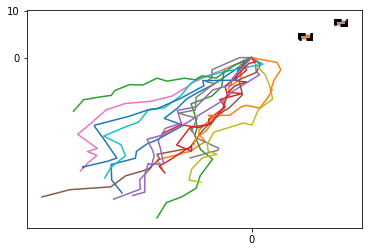

In [133]:
axes = plt.axes()
plot_trajs(axes, ts_by_time[499][0:20])
plt.show()